In [84]:
import pandas as pd
from scipy import stats
import re
import matplotlib.pyplot as plt
import pingouin as pg

# WARNING - Running cells multiple times will result in incorrect results
(because they edit the underlying dataframes)

# Prepare data
### 1. Read data

In [85]:
participant_information = pd.read_csv('./data/participant-information-with-tokens.csv')
password_survey = pd.read_csv('./data/password-survey-with-tokens.csv')
password_survey_acceptance = pd.read_csv('./data/password-survey-acceptance.csv')
password_survey_acceptance.add_prefix('ACCEPTANCE_')
key_setup_survey = pd.read_csv('./data/key-setup-with-token.csv')
key_setup_acceptance = pd.read_csv('./data/key-setup-acceptance.csv')
final_survey = pd.read_csv('./data/check-week-3-final.csv')
final_survey_acceptance = pd.read_csv('./data/check-week-3-final-acceptance.csv')
password_survey_merged = pd.merge(password_survey, password_survey_acceptance, on="Response ID")
key_setup_survey_merged = pd.merge(key_setup_survey, key_setup_acceptance, on="Response ID")
final_survery_merged = pd.merge(final_survey, final_survey_acceptance, on="Response ID")

### 2. Prepare data

In [86]:
# sort all dataframes by token to make sure they are in the same order
# which is important later on for Paired T-Tests
participant_information = participant_information.sort_values(by=['Token'])
password_survey_merged = password_survey_merged.sort_values(by=['Token'])
key_setup_survey_merged = key_setup_survey_merged.sort_values(by=['Token'])

# Participant information
### 1. Education level

Text(0, 0.5, 'Count')

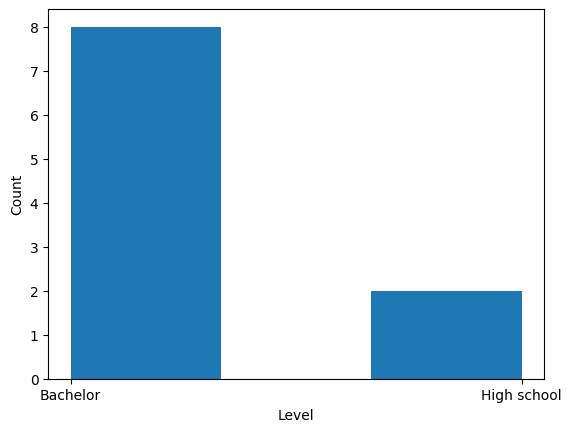

In [87]:
# plot different histograms of the different survery participant information
ax = participant_information['Highest attained educational level'].hist(bins=3, grid=False)
ax.set_xlabel("Level")
ax.set_ylabel("Count")

### 2. CS Background

Text(0, 0.5, 'Count')

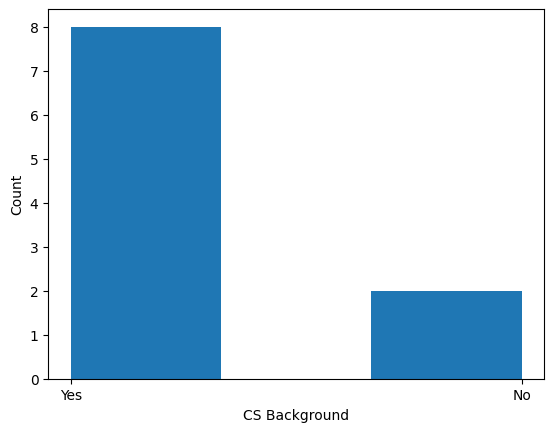

In [88]:
ax = participant_information["Do you have computer science background?"].hist(bins=3, grid=False)
ax.set_xlabel("CS Background")
ax.set_ylabel("Count")

### 3. Gender

Text(0, 0.5, 'Count')

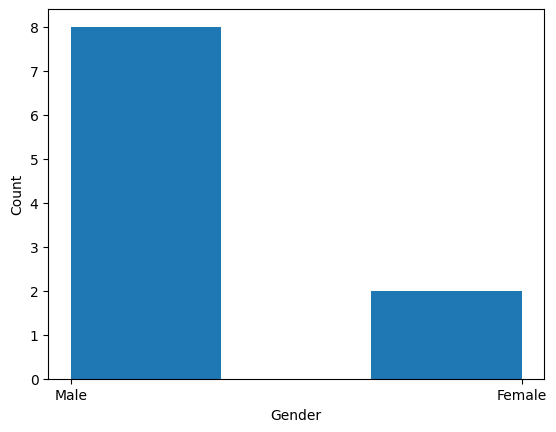

In [89]:
ax = participant_information["Gender"].hist(bins=3, grid=False)
ax.set_xlabel("Gender")
ax.set_ylabel("Count")

### 4. Age

Text(0, 0.5, 'Count')

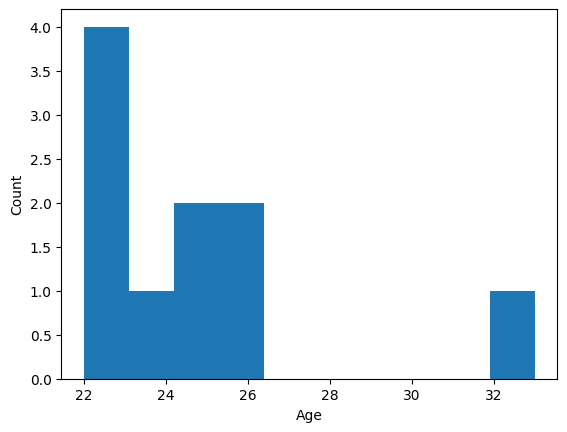

In [90]:
ax = participant_information["Age"].hist(grid=False, )
ax.set_xlabel("Age")
ax.set_ylabel("Count")

# Affinity For Technology
same as the last two scales ATI also has a standard method for evaluating

In [91]:
def freedman_diaconis_bins(data: pd.Series)->int:
    # optimal number of bins using Freedman-Diaconis rule
    # https://www.wikiwand.com/en/Freedman%E2%80%93Diaconis_rule
    iqr = stats.iqr(data)
    n = len(data)
    return int((data.max() - data.min()) / (2 * iqr * n ** (-1/3)))

In [92]:
def calcualte_affinity_for_technology(
    df: pd.DataFrame, column_selector: str
) -> (float, float):
    # columns are consiered to be in the correct order
    columns = [c for c in df.columns if re.match(column_selector, c)]
    # display(df[columns])

    # replace the strings with numbers
    df[columns] = df[columns].replace(
        [
            "Completely disagree",
            "Largely disagree",
            "Slightly disagree",
            "Slightly agree",
            "Largely agree",
            "Completely agree",
        ],
        [1, 2, 3, 4, 5, 6],
    )

    # reverse negative questions 3, 6 and 8
    neg_columns = [columns[i] for i in [2, 5, 7]]
    df[neg_columns] = df[neg_columns].apply(lambda x: 7 - x)

    # calculate the mean of the columns
    ati = df[columns].mean(axis=1)

    # calculate Cronbach’s alpha
    alpha = pg.cronbach_alpha(data=df[columns])

    return ati, alpha

Chronbach's alpha for ATI:  (0.7032777978993119, array([0.319, 0.913]))
Check https://www.statology.org/cronbachs-alpha-in-python/
Mean ATI: 4.37 > 3.0 => positive affinity for technology


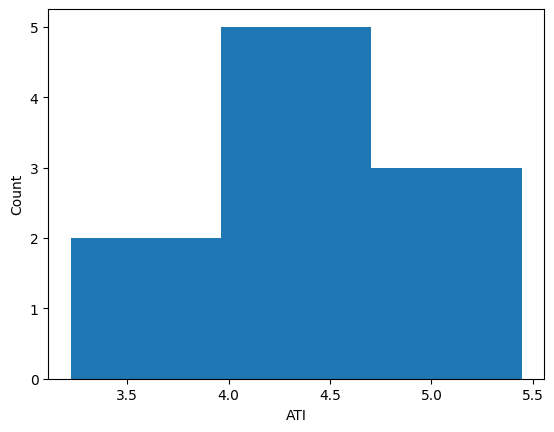

In [93]:
ATI_Question = (
    "In the following, we will ask you about your interaction with technical systems."
)
ATIs, alpha = calcualte_affinity_for_technology(password_survey_merged, ATI_Question)

# plot the ATI
ax = ATIs.hist(grid=False, bins=freedman_diaconis_bins(ATIs))
ax.set_xlabel("ATI")
ax.set_ylabel("Count")

print("Chronbach's alpha for ATI: ", alpha)
print("Check https://www.statology.org/cronbachs-alpha-in-python/")

print(f"Mean ATI: {round(ATIs.mean() , 2)} > 3.0 => positive affinity for technology")

# SUS Analysis

System Usability Scale has standard method for evaluation and calcualting the score defined [here](https://www.usability.gov/how-to-and-tools/methods/system-usability-scale.html)

### 1. First we calculate the different SUS values

In [94]:
def calculate_sus_score(df: pd.DataFrame, column_selector: str)->(float, float):
    """
    https://www.researchgate.net/publication/228593520_SUS_A_quick_and_dirty_usability_scale
    """
    columns = [c for c in df.columns if re.match(column_selector, c)]
    
    # normalize values to 0-4
    df[columns] = df[columns].replace(
        ["1 - Strongly disagree", "5 - Strongly agree"],
        [1, 5],
    )
    
    # convert to numeric and substract 1
    df[columns] = df[columns].apply(pd.to_numeric) - 1

    # reverse negative questions
    neg_columns = [columns[i] for i in range(1, len(columns), 2)]
    df[neg_columns] = df[neg_columns].apply(lambda row: 4 - row)

    # calculate SUS score
    score = df[columns].sum(axis=1) * 2.5
    return score.mean(), score.std(), score

In [95]:
SUS_Question = "Please state your level of agreement or disagreement for the following statements based on your experience with the .*? method. There are no right or wrong answers"
key_setup_sus_score = calculate_sus_score(key_setup_survey_merged, SUS_Question)
password_sus_score = calculate_sus_score(password_survey_merged, SUS_Question)
final_sus_score = calculate_sus_score(final_survery_merged, SUS_Question)

print('Password SUS score: ', password_sus_score[0])
print('Key setup SUS score: ', key_setup_sus_score[0])
print('Final SUS score: ', final_sus_score[0])

Password SUS score:  69.25
Key setup SUS score:  71.0
Final SUS score:  74.5


### 2. Do Paired T-Tests
#### a. Check data distribution

In [96]:
def plot_histogram(data: pd.Series, title: str, xlabel: str, ylabel: str):
    bins = freedman_diaconis_bins(data)
    ax = data.plot.hist(bins=bins, title=title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # ax.grid(axis='y', alpha=0.)

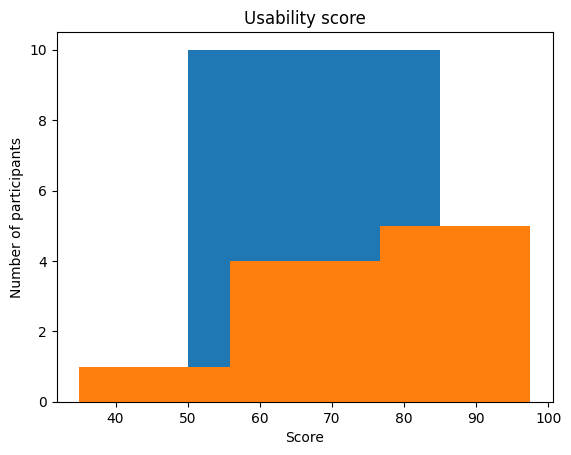

In [97]:
plot_histogram(password_sus_score[2], 'Usability score', 'Score', 'Number of participants')
plot_histogram(key_setup_sus_score[2], 'Usability score', 'Score', 'Number of participants')
# plot_histogram(final_sus_score[2], 'Final SUS score', 'Score', 'Number of participants')

#### b. Calculate P-Values

In [98]:
res = stats.ttest_rel(password_sus_score[2], key_setup_sus_score[2])

print('Paired T-Test: ', res)
print(f'P-Value: {res.pvalue:.4f} > 0.05 => H0 cannot be rejected')

Paired T-Test:  TtestResult(statistic=-0.2852197475138899, pvalue=0.7819307299481828, df=9)
P-Value: 0.7819 > 0.05 => H0 cannot be rejected


# Acceptance Scale analysis

Acceptnace scale also has standard method for evaluation and calculating the score, defined [here](https://www.hfes-europe.org/accept/accept.htm)

### 1. First we calculate the different Acceptance values

In [99]:
def calculate_acceptance_score(df: pd.DataFrame, column_selector: str)->(float, float):
    # columns are considered to be in order
    columns = [c for c in df.columns if re.match(column_selector, c)]
    
    # replace values "AX" -> X  and parse to numeric
    df[columns] = df[columns].replace(r'A([12345])',r'\1' ,regex=True).apply(pd.to_numeric)
    # display(df[columns])
    
    # invert scores for questions 3, 6, and 8 (negative questions)
    neg_columns = [columns[i] for i in [2, 5, 7]]
    df[neg_columns] = df[neg_columns].apply(lambda row: 6 - row)
    
    # convert values to 2 to -2
    df[columns] = df[columns].apply(lambda row: 3 - row)
    # display(df[columns])
    
    # The Usefulness scale is the sum of item 1 + 3 + 5 + 7 + 9 divided by 5 (so it has a range from -2 to +2)
    usefullness_score = df[[columns[i] for i in [0, 2, 4, 6, 8]]].sum(axis=1) / 5
    # the Satisfying scale is the sum of items 2, 4, 6, and 8, divided by 4.
    satisfying_score = df[[columns[i] for i in [1, 3, 5, 7]]].sum(axis=1) / 4
    
    return usefullness_score.mean(), satisfying_score.mean(), usefullness_score, satisfying_score

Password 	usefullness score: 0.62 / satisfying score: 0.25
Key setup 	usefullness score: 0.96 / satisfying score: 0.825
Final 		usefullness score: 0.92 / satisfying score: 0.825

In [100]:
ACC_Question = "Please judge the .*? authentication method on the following adjectives.  "

key_setup_acc_score = calculate_acceptance_score(key_setup_survey_merged, ACC_Question)
password_acc_score = calculate_acceptance_score(password_survey_merged, ACC_Question)
final_acc_score = calculate_acceptance_score(final_survery_merged, ACC_Question)

print(f'Password \tusefullness score: {password_acc_score[0]} / satisfying score: {password_acc_score[1]}')
print(f'Key setup \tusefullness score: {key_setup_acc_score[0]} / satisfying score: {key_setup_acc_score[1]}')
print(f'Final \t\tusefullness score: {round(final_acc_score[0], 2)} / satisfying score: {final_acc_score[1]}')

Password 	usefullness score: 0.62 / satisfying score: 0.25
Key setup 	usefullness score: 0.9600000000000002 / satisfying score: 0.825
Final 		usefullness score: 0.92 / satisfying score: 0.825


### 2. Do Paired T-Test
#### a. Check data distribution

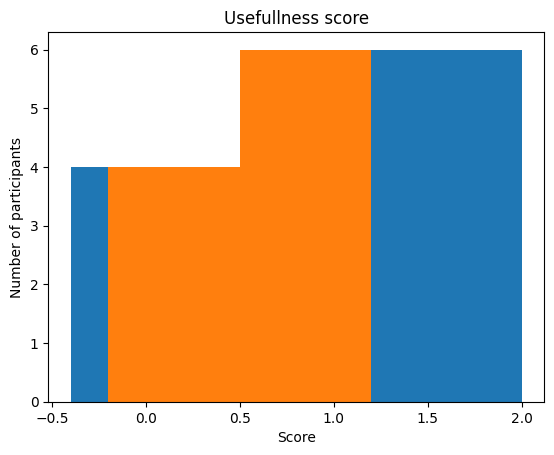

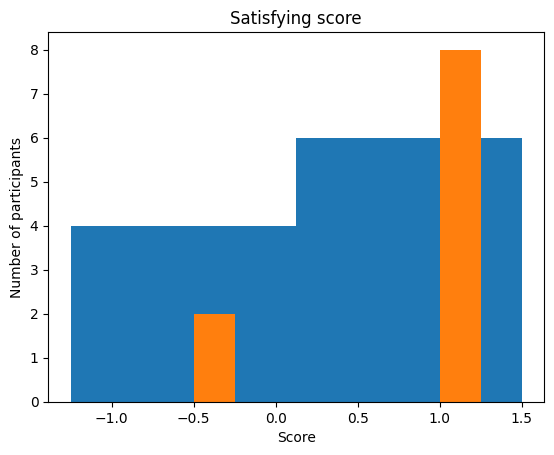

In [101]:
plot_histogram(key_setup_acc_score[2], 'Usefullness score', 'Score', 'Number of participants')
plot_histogram(password_acc_score[2], 'Usefullness score', 'Score', 'Number of participants')

# start new figure
plt.figure()

plot_histogram(password_acc_score[3], 'Satisfying score', 'Score', 'Number of participants')
plot_histogram(key_setup_acc_score[3], 'Satisfying score', 'Score', 'Number of participants')



#### b. Calculate P-Values
for Usefullness

In [102]:
res = stats.ttest_rel(password_acc_score[2], key_setup_acc_score[2])
print('Paired T-Test: ', res)
print(f'P-Value: {res.pvalue:.4f} > 0.05 => H0 cannot be rejected')

Paired T-Test:  TtestResult(statistic=-1.3625457971204253, pvalue=0.20614414992672614, df=9)
P-Value: 0.2061 > 0.05 => H0 cannot be rejected


for satisfying

In [103]:
res = stats.ttest_rel(password_acc_score[3], key_setup_acc_score[3])
print('Paired T-Test: ', res)
print(f'P-Value: {res.pvalue:.4f} > 0.05 => H0 cannot be rejected')

Paired T-Test:  TtestResult(statistic=-1.363465965002295, pvalue=0.20586471915457005, df=9)
P-Value: 0.2059 > 0.05 => H0 cannot be rejected
